In [1]:
import numpy as np
import math
import scipy.spatial
import scipy.optimize
from scipy.spatial import Delaunay
from scipy.optimize import root
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.path import Path
%matplotlib inline

In [2]:
path = '/Users/deniszagorodnev/Desktop/4course/Инструментальные средства/pics'

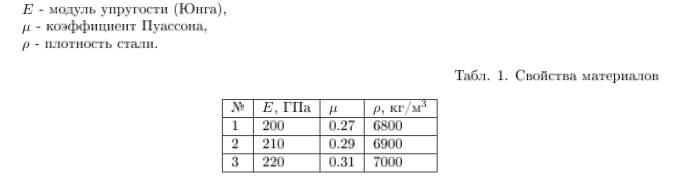

In [3]:
Image(filename = path + '/features.png') 

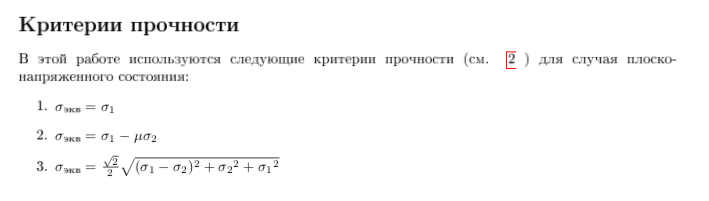

In [4]:
Image(filename = path + '/criteria.png') 

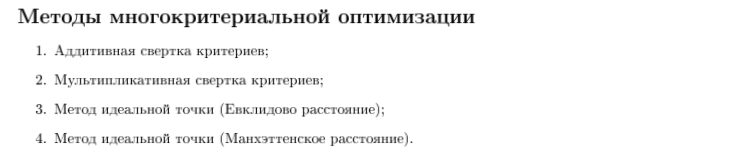

In [5]:
Image(filename = path + '/methods.png') 

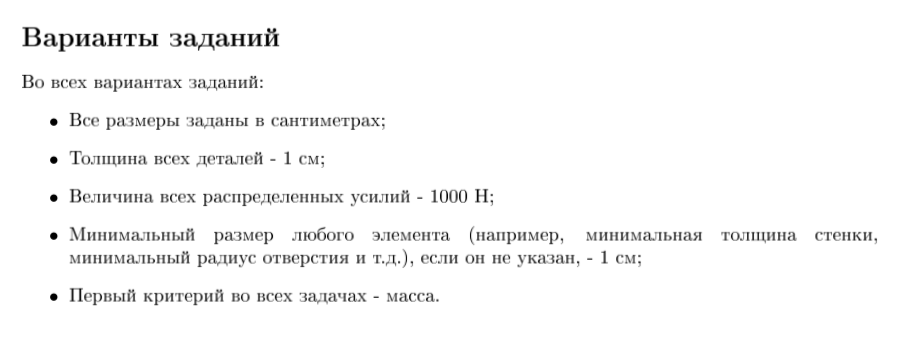

In [6]:
Image(filename = path + '/remarks.png') 

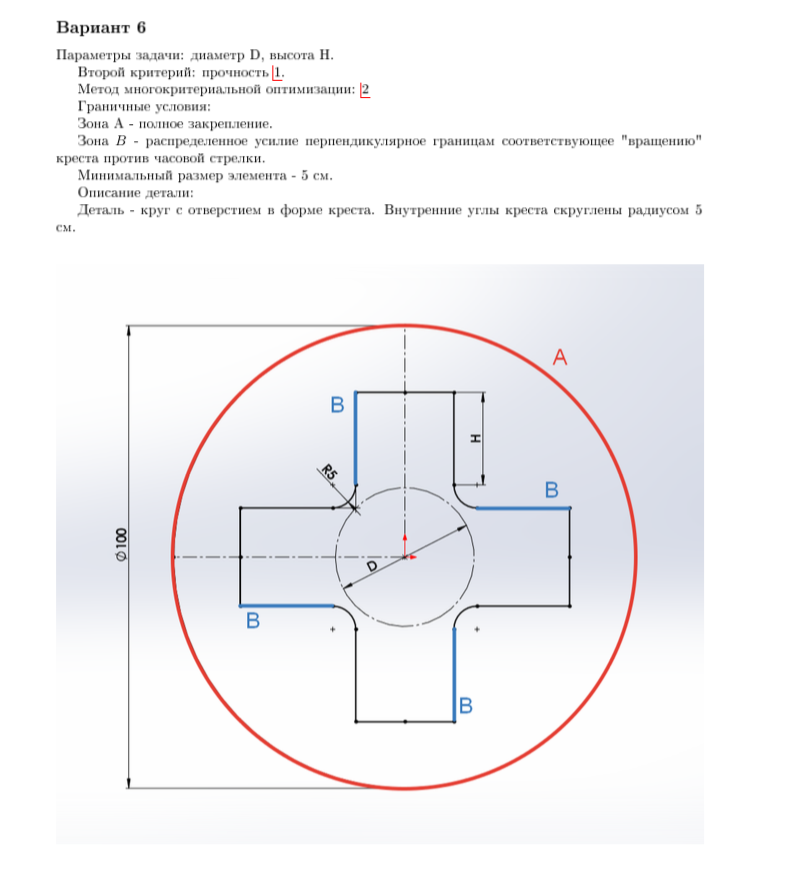

In [7]:
Image(filename = path + '/task.png') 

In [8]:
Diam = 100 # см, диаметр круга
R = 5 #см, радиус скругления винта
t = 1 # см, толщина детали

In [9]:
#параметры задачи
d = 14 # см, диаметр отверстия
H = 10 # см, длина ребра винта 

In [10]:
E = 2.2e7 
mu = 0.31 
matrix = E / (1-mu**2)*np.array([[1,mu,0],[mu,1,0],[0,0,(1-mu)/2]]) # матрица упругих постоянных
rho = 7000/100**3 
p = 1000 
alpha = np.deg2rad(0)
px, py = p*np.cos(alpha), p*np.sin(alpha)

In [11]:
#генерация узлов и элементов по геометрическим праметрам

def gen_Nodes_Elems(H, R, D, d):
    g = 1
    a = d*np.sin(np.pi/4)

    alpha = np.arange(0, 2*np.pi, g/(0.5*D))

    G0x = (D/2)*np.cos(alpha)
    G0y = (D/2)*np.sin(alpha)
    Gout = np.vstack((G0x, G0y)).T
    
    G1y = np.arange(-a/2, a/2, g)
    G1x = np.zeros_like(G1y)  - (H + R + a/2)

    G2x = np.arange(- (H + R + a/2), - (R + a/2), g) 
    G2y = np.zeros_like(G2x) + a/2

    alpha = np.arange(np.pi*3/2, 2*np.pi, g/(R))
    G3x = -a/2 - R + R*np.cos(alpha)
    G3y = R*np.sin(alpha) + a/2 + R

    G4y = np.arange(a/2 + R, a/2 + R + H, g) 
    G4x = np.zeros_like(G4y) - a/2

    G5x = np.arange(- a/2, a/2, g) 
    G5y = np.zeros_like(G5x) + a/2 + R + H

    G6y = np.arange(a/2 + R + H, a/2 + R, - g) 
    G6x = np.zeros_like(G6y) + a/2

    alpha = np.arange(np.pi, np.pi*3/2, g/(R))
    G7x =  a/2 + R + R*np.cos(alpha)
    G7y = R*np.sin(alpha) + a/2 + R

    G8x = np.arange(a/2 + R, a/2 + R + H, g) 
    G8y = np.zeros_like(G8x) + a/2 

    G9y = np.arange(a/2, -a/2, -g)
    G9x = np.zeros_like(G9y)  + (H + R + a/2)

    G10x = np.arange(a/2 + R + H, a/2 + R, -g) 
    G10y = np.zeros_like(G10x) - a/2 

    alpha = np.arange(np.pi/2, np.pi, g/(R))
    G11x =  a/2 + R + R*np.cos(alpha)
    G11y = R*np.sin(alpha) - a/2 - R

    G12y = np.arange(-(a/2 + R), -(a/2 + R + H), -g)
    G12x = np.zeros_like(G12y)  + (a/2)

    G13x = np.arange(a/2, -a/2, -g) 
    G13y = np.zeros_like(G13x) - (a/2 + R + H) 

    G14y = np.arange(-(a/2 + R + H), -(a/2 + R), g)
    G14x = np.zeros_like(G14y)  - (a/2)

    alpha = np.arange(0, np.pi/2, g/(R))
    G15x =  -a/2 - R + R*np.cos(alpha)
    G15y = R*np.sin(alpha) - a/2 - R

    G16x = np.arange(-(a/2 + R), -(a/2 + R + H), -g) 
    G16y = np.zeros_like(G16x) - (a/2) 
    
    #внутренняя граница
    Gin0 = np.vstack((
                        np.vstack((G1x, G1y)).T,
                        np.vstack((G2x, G2y)).T,
                        np.vstack((G3x, G3y)).T,
                        np.vstack((G4x, G4y)).T,
                        np.vstack((G5x, G5y)).T,
                        np.vstack((G6x, G6y)).T,
                        np.vstack((G7x, G7y)).T,
                        np.vstack((G8x, G8y)).T,
                        np.vstack((G9x, G9y)).T,
                        np.vstack((G10x, G10y)).T,
                        np.vstack((G11x, G11y)).T,
                        np.vstack((G12x, G12y)).T,
                        np.vstack((G13x, G13y)).T,
                        np.vstack((G14x, G14y)).T,
                        np.vstack((G15x, G15y)).T,
                        np.vstack((G16x, G16y)).T,

                       ))
    
    margin = 0.1
    x = np.linspace(-D/2-margin, D/2-margin, 40)
    y = np.linspace(-D/2-margin, D/2-margin, 40)
    X, Y = np.meshgrid(x, y)
    INodes = np.vstack((X.ravel(), Y.ravel())).T
    xdata = X.ravel()
    ydata = Y.ravel()
    imask2 = np.sum((INodes )**2,axis=1) < (D/2)**2
    INodes = INodes[imask2]
    path = Path(Gin0)
    imask0 = np.logical_not(path.contains_points(INodes, radius = 0.001))
    INodes = INodes[imask0]
    
    Nodes = np.vstack((Gout, Gin0,INodes))
    tri = Delaunay(Nodes)
    Elems = tri.simplices.copy()
    Elems = tri.simplices.copy()
    emask = np.any(Elems >= Nodes.shape[0] - INodes.shape[0], axis=1)
    Elems = Elems[emask]
    
    return Nodes, Elems

In [12]:
#генерация нужных для решения матриц

def gen_EFT_K_A_B_D(Nodes, Elems):
    Coords = Nodes[Elems]
    A = 0.5 * np.cross(Coords[:,1] - Coords[:,0], Coords[:,2] - Coords[:,0])
    b = np.roll(Coords[:,:,1], -1, axis = 1) - np.roll(Coords[:,:,1], 1, axis = 1)
    c = np.roll(Coords[:,:,0], 1, axis = 1) - np.roll(Coords[:,:,0], -1, axis = 1)

    B = np.zeros((Elems.shape[0],3,6))

    B[:,0,0::2] = b
    B[:,1,1::2] = c

    B[:,2,1::2] = b
    B[:,2,0::2] = c

    B *= 1/(2*A[:,None,None])
    Bt = np.transpose(B, axes=(0,2,1))

    D = (E/(1 - mu**2)) * np.array([[1, mu, 0], [mu, 1, 0], [0, 0, (1 - mu)/2]])

    Bt = np.zeros([len(A), 6, 3])

    for i in range (0, len(A)):
        prom = np.array([[b[i][0], 0, b[i][1], 0, b[i][2], 0],
                            [0, c[i][0], 0, c[i][1], 0, c[i][2]],
                            [c[i][0], b[i][0], c[i][1], b[i][1], c[i][2], b[i][2]]])

        Bt[i] = (1/(2*A[i]))*prom.T

    Ke = Bt@D@B
    EFT = 2*Elems[:, [0,0,1,1,2,2]] + np.array([0,1,0,1,0,1])

    K = np.zeros((2*Nodes.shape[0],)*2)
    for i, e in enumerate(Elems):
        K[EFT[i,None].T, EFT[i]] += Ke[i]
        
    return A, B, EFT, K, D


    

In [13]:
#построение фигуры с триангуляцией

def plot_trigs(d, H, size = 15):
    Nodes, Elems = gen_Nodes_Elems(H, R, Diam, d)
    A, B, EFT, K, D = gen_EFT_K_A_B_D(Nodes, Elems)
    plt.figure(figsize = (size, size));
    plt.triplot(Nodes[:,0], Nodes[:,1], Elems);
    plt.plot(Nodes[:,0], Nodes[:,1], '.', color = 'red')
    for i, Node in enumerate(Nodes):
        plt.text(Node[0], Node[1], s=i)

    plt.show()

In [14]:
#проверка корректности составленной матрицы К
def check_K_corr(K):
    if math.isnan(np.linalg.det(K)) or np.linalg.det(K) == 0:
        return None
    else:
        return 1

In [15]:
#ща будет расчет прочности

In [16]:
#критерий прочности 1
def yield1(S1, S2, **kwargs):
    return S1

yield_f = lambda S1, S2: yield1(S1, S2)

In [17]:
#пересчет нагрузки на узлы

def calcNodeSig(U, EFT, B, D, A, Nn, Elems):
    
    ElemU = U[EFT, np.newaxis]
    ElemEps = np.matmul(B, ElemU)
    ElemSig = np.matmul(D, ElemEps)
    NodeSig = np.zeros((Nn, 3))
    NodeA = np.zeros(Nn)
    for i in range(Elems.shape[0]):
        NodeSig[Elems[i]] += ElemSig[i].T * A[i]
        NodeA[Elems[i]] += A[i]
    NodeSig /= NodeA.reshape(-1,1)
    
    return NodeSig

In [18]:

def calcS1S2(NodeSig):
    
    p1 = 0.5*(NodeSig[:,0] + NodeSig[:,1])
    p2 = np.sqrt((0.5*(NodeSig[:,0]-NodeSig[:,1]))**2+NodeSig[:,2]**2)
    
    return p1+p2, p1-p2

In [19]:
#определить номера фиксированных и нагруженых кусков по принадлежности к части детали 

def find_fixed_forced(H, d):
    Nodes, Elems = gen_Nodes_Elems(H, R, Diam, d)
    g = 1
    a = d*np.sin(np.pi/4)
    alpha = np.arange(0, 2*np.pi, g/(0.5*Diam))
    G_fixed = np.vstack(((Diam/2)*np.cos(alpha), (Diam/2)*np.sin(alpha))).T
    fixed = []
    for i in range(len(Nodes)):
        if Nodes[i] in G_fixed:
            fixed.append(i)
    fixed = np.array(fixed)
    
    
    forced = []
    
    G4y = np.arange(a/2 + R, a/2 + R + H, g) 
    G4x = np.zeros_like(G4y) - a/2
    
    G_forced_4 = np.vstack((G4x, G4y)).T
    for i in range(len(Nodes)):
        if Nodes[i] in G_forced_4 and Nodes[i][1] > 0:
                forced.append(i)
                
    G8x = np.arange(a/2 + R, a/2 + R + H, g) 
    G8y = np.zeros_like(G8x) + a/2 

    G_forced_8 = np.vstack((G8x, G8y)).T
    for i in range(len(Nodes)):
        if Nodes[i] in G_forced_8 and Nodes[i][0] > 0:
                    forced.append(i)
    forced.remove(max(forced)) 
    
    G12y = np.arange(-(a/2 + R), -(a/2 + R + H), -g)
    G12x = np.zeros_like(G12y)  + (a/2) 

    G_forced_12 = np.vstack((G12x, G12y)).T
    for i in range(len(Nodes)):
        if Nodes[i] in G_forced_12 and Nodes[i][1] < 0:
                forced.append(i)
    forced.remove(max(forced))

    
    G16x = np.arange(-(a/2 + R), -(a/2 + R + H), -g) 
    G16y = np.zeros_like(G16x) - (a/2)

    G_forced_16 = np.vstack((G16x, G16y)).T
    for i in range(len(Nodes)):
        if Nodes[i] in G_forced_16 and Nodes[i][0] < 0:
                forced.append(i)


    
    forced = np.array(forced)
    

    dof = np.hstack((fixed*2, fixed*2+1))

    bc = {'zero':dof, 'pressure':(forced, (px, py))}
    
    return bc

In [20]:
#критерий прочность
def calcMaxYield(H, R, D, d):  
    
    Nodes, Elems = gen_Nodes_Elems(H, R, D, d)
    
    A, B, EFT, K, D = gen_EFT_K_A_B_D(Nodes, Elems)
    F = np.zeros(Nodes.shape[0]*2)
    
    bc = find_fixed_forced(H, d)
    
    bc_p, f = bc['pressure']
    L_p = np.linalg.norm(Nodes[bc_p[1:]] - Nodes[bc_p[:-1]], axis=1)
    for i in range(len(L_p)):
        F[bc_p[[i, i+1]]*2] += L_p[i]*t*p*0.5  
        
    dof = bc['zero']
    K[dof, :] = 0
    K[:, dof] = 0
    K[dof, dof] = 1
    F[dof] = 0

    if check_K_corr(K) == None:
        return None

    U = np.linalg.solve(K, F)
    
    NodeSig = calcNodeSig(U, EFT, B, D, A, Nodes.shape[0], Elems)
    
    S1, S2 = calcS1S2(NodeSig)
    
    max_yield = np.max(np.abs(yield_f(S1, S2)))
    
    return max_yield

In [21]:
#критерий масса
def mass_empiric(H, R, D, d):   
    
    a = d*np.sin(np.pi/4)
    mass = (np.pi*(D/2)**2 - 4*H*a - a**2 - R*a - (R**2 - np.pi*R**2))*t*rho
    
    return mass

#вычисление массы для оптимизации
def mass(Nodes, Elems):
    ElemC = Nodes[Elems]
    a = ElemC[:,0]
    b = ElemC[:,1]
    c = ElemC[:,2]

    ab = b - a
    ac = c - a
    
    res = 0.5*(ab[:,0]*ac[:,1]-ab[:,1]*ac[:,0])
    res = res.reshape(-1,1)
    return np.sum(res)*t*rho

In [22]:
#неравенства для параметров задачи:

# нижняя граница
def inequ_low(H, d):
    
    return (H > 5) == True and (d > 5) == True

#верхняя гранца
def inequ_high(H, d):
    
    a = d*np.sin(np.pi/4)
    h = a/2 + H + R
    return np.sqrt((h**2 + (a/2)**2)) < 50

In [23]:
#метод - мультипликативная свертка критериев

w1 = 0.2

#целевой функционал. веса выбраны по принципу равного влияния

def aim_func(H, R, D, d, w1, lst):
    
    if inequ_low(H, d) and inequ_high(H, d) and (w1 < 1):
        
        lst.append([H,d])
        w2 = 1 - w1
        Nodes, Elems = gen_Nodes_Elems(H, R, D, d)
        #тут следует нормировать массу и нагрузку вследствие разности порядков. нужно разделить на max массы и тд
        res1 = mass(Nodes, Elems)
        res2 = calcMaxYield(H, R, D, d)
        if res2 == None:
            return 1e15
#свертка из функций mass и calcYeld с весами, заданными вручную. Веса также можно сделать параметром оптимизации.
        return (res1**w1)*(res2**w2)
        
    
    else:

        return 1e15


In [24]:
#для построения области точек, отвечающих критериям 

def gen_criteria_map(possible_map):
    
    res = possible_map
    crit_lst = []
    
    
    for elem in res:
        H = elem[0]
        d = elem[1]
        Nodes, Elems = gen_Nodes_Elems(H, R, Diam, d)
        m = mass(Nodes, Elems)
        y = calcMaxYield(H, R, Diam, d)
        crit_lst.append([m, y])
    return np.array(crit_lst)


#для построения области допустимых значений

def get_possible_map(n_dots):
    H_range = np.linspace(5, 100, n_dots)
    d_range = np.linspace(5, 100, n_dots)

    lst_res = []

    for H in H_range:
        for d in d_range:
            if inequ_low(H, d) == True and inequ_high(H, d) == True:
                lst_res.append([H, d])
    res = np.array(lst_res)
    return res

In [25]:


pos = get_possible_map(50)

crit = gen_criteria_map(pos)


/Users/deniszagorodnev/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


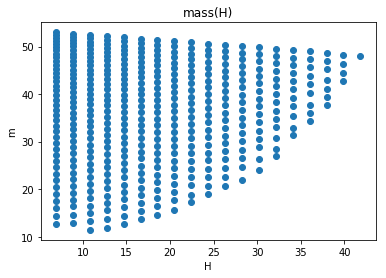

In [26]:
plt.plot(pos[:,0], crit[:,0], 'o');
plt.xlabel('H');
plt.ylabel('m');
plt.title('mass(H)');

#plt.plot(crit[:,0], crit[:,1], 'o');

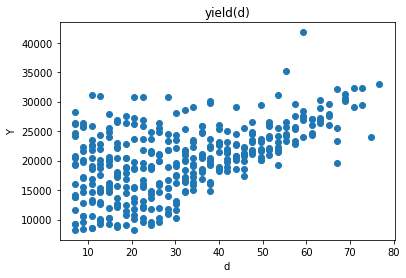

In [27]:
plt.plot(pos[:,1], crit[:,1], 'o');
plt.xlabel('d');
plt.ylabel('Y');
plt.title('yield(d)');



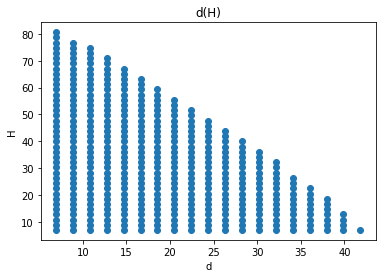

In [28]:
plt.plot(pos[:,0], pos[:,1], 'o');
plt.xlabel('d');
plt.ylabel('H');
plt.title('d(H)');




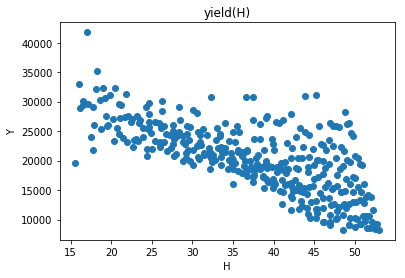

In [29]:
plt.plot(crit[:,0], crit[:,1], 'o');
plt.xlabel('H');
plt.ylabel('Y');
plt.title('yield(H)');

In [30]:
np.savetxt("pos.csv", pos)
np.savetxt("crit.csv", np.array(crit, float))

In [31]:
def F1(H, R, D, d, w1, lst):
    
        w2 = 1 - w1
        res1 = mass(Nodes, Elems)
        res2 = calcMaxYield(H, R, D, d)
        if res2 == None:
            return 1e15
        return (res1**w1)*(res2**2)





#H_range = np.linspace(5, 100, 100)
#d_range = np.linspace(5, 100, 100)

#X, Y = np.meshgrid(H_range, d_range)
#Z = F1(X, R, Diam, Y, w1, [])
#plt.contourf(X, Y, np.log(np.array(Z)))

In [32]:
lst = []
initial_guess = [32, 26]



ret = scipy.optimize.minimize(lambda initial_guess, lst: aim_func(initial_guess[0], R, Diam, initial_guess[1], w1, lst), initial_guess, args=(lst), 
                             method='Nelder-Mead', 
                    options={'xatol': 1e-9, 'disp': True, 'maxiter':100000})
arr = np.array(lst)

/Users/deniszagorodnev/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Optimization terminated successfully.
         Current function value: 2523.370428
         Iterations: 95
         Function evaluations: 258


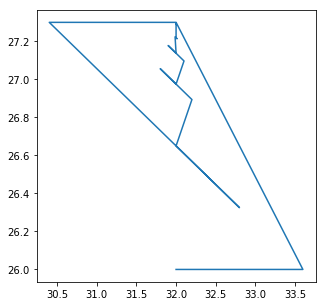

In [33]:
plt.figure(figsize=(5,5))
#plt.plot(ret.x[0], ret.x[1], 'o')
plt.plot(arr[:,0], arr[:,1])

/Users/deniszagorodnev/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


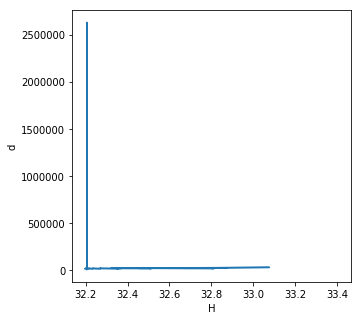

In [35]:
plt.figure(figsize=(5,5))
#plt.plot(crit[:,0], crit[:,1], 'o');
lst = []
for i in range(len(arr)):
    H = arr[:,0][i]
    d = arr[:,1][i]
    Nodes, Elems = gen_Nodes_Elems(H, R, Diam, d)
    m = mass(Nodes, Elems)
    y = calcMaxYield(H, R, Diam, d)
    lst.append([m, y])
plt.xlabel('H');
plt.ylabel('d');
#plt.xlim(8, 12)
#plt.ylim(10, 20)

arr = np.array(lst)
plt.plot(arr[:,0], arr[:,1])

In [36]:
H_opt = round(ret.x[0])
D_opt = round(ret.x[1])

/Users/deniszagorodnev/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


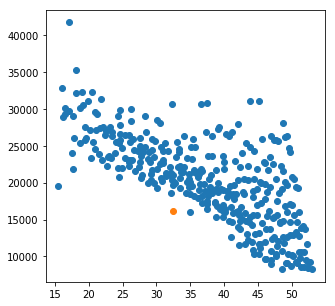

In [37]:

plt.figure(figsize=(5,5))
Nodes, Elems = gen_Nodes_Elems(H_opt, R, Diam, D_opt)
m = mass(Nodes, Elems)
y = calcMaxYield(H_opt, R, Diam, D_opt)
plt.plot(crit[:,0], crit[:,1], 'o');
plt.plot(m, y, 'o')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
pos = np.loadtxt("pos.csv")
crit = np.loadtxt("crit.csv")

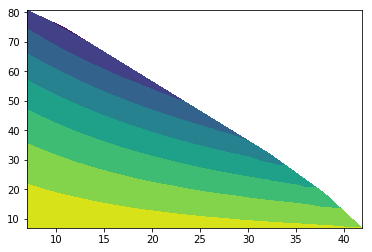

In [38]:
pos[pos[:,0] == np.nan, 0] = 0
pos[pos[:,1] == np.nan, 1] = 0
crit[crit[:,0] == np.nan, 0] = 0

cont = plt.tricontourf(pos[:,0], pos[:,1], np.array(crit[:,0], float))


In [39]:
cr = np.array(crit[:,1], float)
for i in range(len(cr)):
    if np.isnan(cr[i]):
        cr[i] = 0


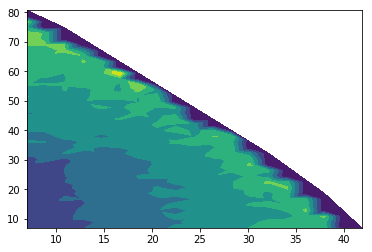

In [40]:
pos[pos[:,0] == np.nan, 0] = 0
pos[pos[:,1] == np.nan, 1] = 0
crit[crit[:,1] == np.nan, 1] = 0

cont = plt.tricontourf(pos[:,0], pos[:,1], cr)



In [41]:
 #plot_trigs(D_opt, H_opt, size = 15)

In [46]:
def plot_color_map(H, d):
    import copy
    Nodes, Elems = gen_Nodes_Elems(H, R, Diam, d)
    A, B, EFT, K, D = gen_EFT_K_A_B_D(Nodes, Elems)
    F = np.zeros(Nodes.shape[0]*2)
    bc = find_fixed_forced(H, d)
    bc_p, f = bc['pressure']
    L_p = np.linalg.norm(Nodes[bc_p[1:]] - Nodes[bc_p[:-1]], axis=1)
    for i in range(len(L_p)):
        F[bc_p[[i, i+1]]*2] += L_p[i]*t*p*0.5     
    dof = bc['zero']
    K[dof, :] = 0
    K[:, dof] = 0
    K[dof, dof] = 1
    F[dof] = 0
    if check_K_corr(K) == None:
        print('check K accuracy')

    U = np.linalg.solve(K, F)
    NodeSig = calcNodeSig(U, EFT, B, D, A, Nodes.shape[0], Elems)
    S0_node = 0.5*(NodeSig[:,0] + NodeSig[:,1]) +  ((0.5*(NodeSig[:,0] - NodeSig[:,1]))**2 + NodeSig[:,2]**2)**0.5
    
    rNodes = Nodes + 100*U.reshape(-1, 2)
    cont = plt.tricontourf(rNodes[:, 0], rNodes[:, 1], Elems, S0_node, cmap='jet')
    
    D = copy.copy(Diam)
    g = 1
    a = d*np.sin(np.pi/4)

    alpha = np.arange(0, 2*np.pi, g/(0.5*D))
    
    G0x = (D/2)*np.cos(alpha)
    G0y = (D/2)*np.sin(alpha)
    Gout = np.vstack((G0x, G0y)).T
    
    G1y = np.arange(-a/2, a/2, g)
    G1x = np.zeros_like(G1y)  - (H + R + a/2)

    G2x = np.arange(- (H + R + a/2), - (R + a/2), g) 
    G2y = np.zeros_like(G2x) + a/2

    alpha = np.arange(np.pi*3/2, 2*np.pi, g/(R))
    G3x = -a/2 - R + R*np.cos(alpha)
    G3y = R*np.sin(alpha) + a/2 + R

    G4y = np.arange(a/2 + R, a/2 + R + H, g) 
    G4x = np.zeros_like(G4y) - a/2

    G5x = np.arange(- a/2, a/2, g) 
    G5y = np.zeros_like(G5x) + a/2 + R + H

    G6y = np.arange(a/2 + R + H, a/2 + R, - g) 
    G6x = np.zeros_like(G6y) + a/2

    alpha = np.arange(np.pi, np.pi*3/2, g/(R))
    G7x =  a/2 + R + R*np.cos(alpha)
    G7y = R*np.sin(alpha) + a/2 + R

    G8x = np.arange(a/2 + R, a/2 + R + H, g) 
    G8y = np.zeros_like(G8x) + a/2 

    G9y = np.arange(a/2, -a/2, -g)
    G9x = np.zeros_like(G9y)  + (H + R + a/2)

    G10x = np.arange(a/2 + R + H, a/2 + R, -g) 
    G10y = np.zeros_like(G10x) - a/2 

    alpha = np.arange(np.pi/2, np.pi, g/(R))
    G11x =  a/2 + R + R*np.cos(alpha)
    G11y = R*np.sin(alpha) - a/2 - R

    G12y = np.arange(-(a/2 + R), -(a/2 + R + H), -g)
    G12x = np.zeros_like(G12y)  + (a/2)

    G13x = np.arange(a/2, -a/2, -g) 
    G13y = np.zeros_like(G13x) - (a/2 + R + H) 

    G14y = np.arange(-(a/2 + R + H), -(a/2 + R), g)
    G14x = np.zeros_like(G14y)  - (a/2)

    alpha = np.arange(0, np.pi/2, g/(R))
    G15x =  -a/2 - R + R*np.cos(alpha)
    G15y = R*np.sin(alpha) - a/2 - R

    G16x = np.arange(-(a/2 + R), -(a/2 + R + H), -g) 
    G16y = np.zeros_like(G16x) - (a/2) 
    
    #внутренняя граница
    Gin0 = np.vstack((
                        np.vstack((G1x, G1y)).T,
                        np.vstack((G2x, G2y)).T,
                        np.vstack((G3x, G3y)).T,
                        np.vstack((G4x, G4y)).T,
                        np.vstack((G5x, G5y)).T,
                        np.vstack((G6x, G6y)).T,
                        np.vstack((G7x, G7y)).T,
                        np.vstack((G8x, G8y)).T,
                        np.vstack((G9x, G9y)).T,
                        np.vstack((G10x, G10y)).T,
                        np.vstack((G11x, G11y)).T,
                        np.vstack((G12x, G12y)).T,
                        np.vstack((G13x, G13y)).T,
                        np.vstack((G14x, G14y)).T,
                        np.vstack((G15x, G15y)).T,
                        np.vstack((G16x, G16y)).T,

                       ))
    
    plt.plot(Gout[:,0], Gout[:,1])
    plt.plot(Gin0[:,0], Gin0[:,1])


    plt.colorbar(cont)
    plt.axis('equal')
    plt.show()

/Users/deniszagorodnev/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


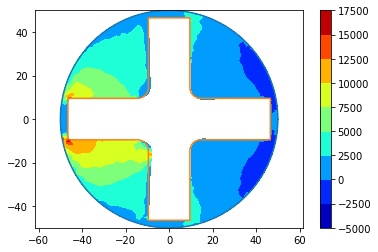

In [47]:
 plot_color_map(H_opt, D_opt)